The following is a demonstration of how LSTM can be used for Stock Price Prediction, however the model not very accurate, and this projects is just a way to practice python knowledge and stock market analytics.

In [214]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [215]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [216]:
# Choosing a company to analyze stock
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

/tmp/ipython-input-2596709339.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [217]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.538506,72.598884,71.292296,71.545882,135480400
2020-01-03,71.833305,72.594071,71.608700,71.765682,146322800
2020-01-06,72.405663,72.444306,70.702997,70.954173,118387200
2020-01-07,72.065155,72.671348,71.845377,72.415345,108872000
2020-01-08,73.224419,73.526310,71.768094,71.768094,132079200


<Axes: xlabel='Date'>

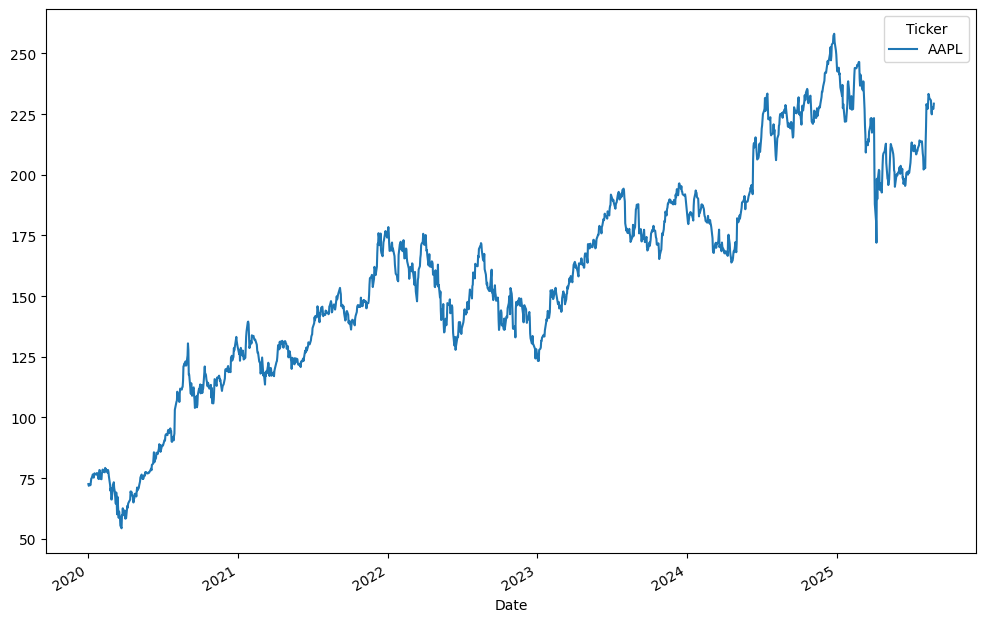

In [218]:
# Plotting the company's closing price for each day from 1st January 2020 till today
df.Close.plot(figsize=(12, 8))

In [219]:
# We are just going to use the closing price of stock to train our model, so we are using Standard Scaler for normalization of closing price
scalar = StandardScaler()

df['Close'] = scalar.fit_transform(df['Close'])

In [220]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.933506
2020-01-03,-1.949248
2020-01-06,-1.936471
2020-01-07,-1.944072
2020-01-08,-1.918194
...,...
2025-08-20,1.492516
2025-08-21,1.467737
2025-08-22,1.531582


In [221]:
seq_len = 20
data = []

for i in range(len(df) - seq_len):
    data.append(df.Close[i : i+seq_len])

data = np.array(data)

In [222]:
# Train - Test Split
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [223]:
class PredictionModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [224]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [225]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [226]:
num_epochs = 120

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 10 == 0:
        print(i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 0.6876357197761536
10 0.07634065300226212
20 0.01448026206344366
30 0.009968934580683708
40 0.0066933417692780495
50 0.005826598033308983
60 0.005274397321045399
70 0.005068264901638031
80 0.0049276757054030895
90 0.004788882099092007
100 0.004669707268476486
110 0.004556835629045963


In [227]:
model.eval()

y_test_pred = model(X_test)

y_train = scalar.inverse_transform(y_train.detach().cpu().numpy())
y_train_pred = scalar.inverse_transform(y_train_pred.detach().cpu().numpy())
y_test = scalar.inverse_transform(y_test.detach().cpu().numpy())
y_test_pred = scalar.inverse_transform(y_test_pred.detach().cpu().numpy())

In [228]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

print(train_rmse)
print(test_rmse)

2.9916975498199463
6.534363269805908


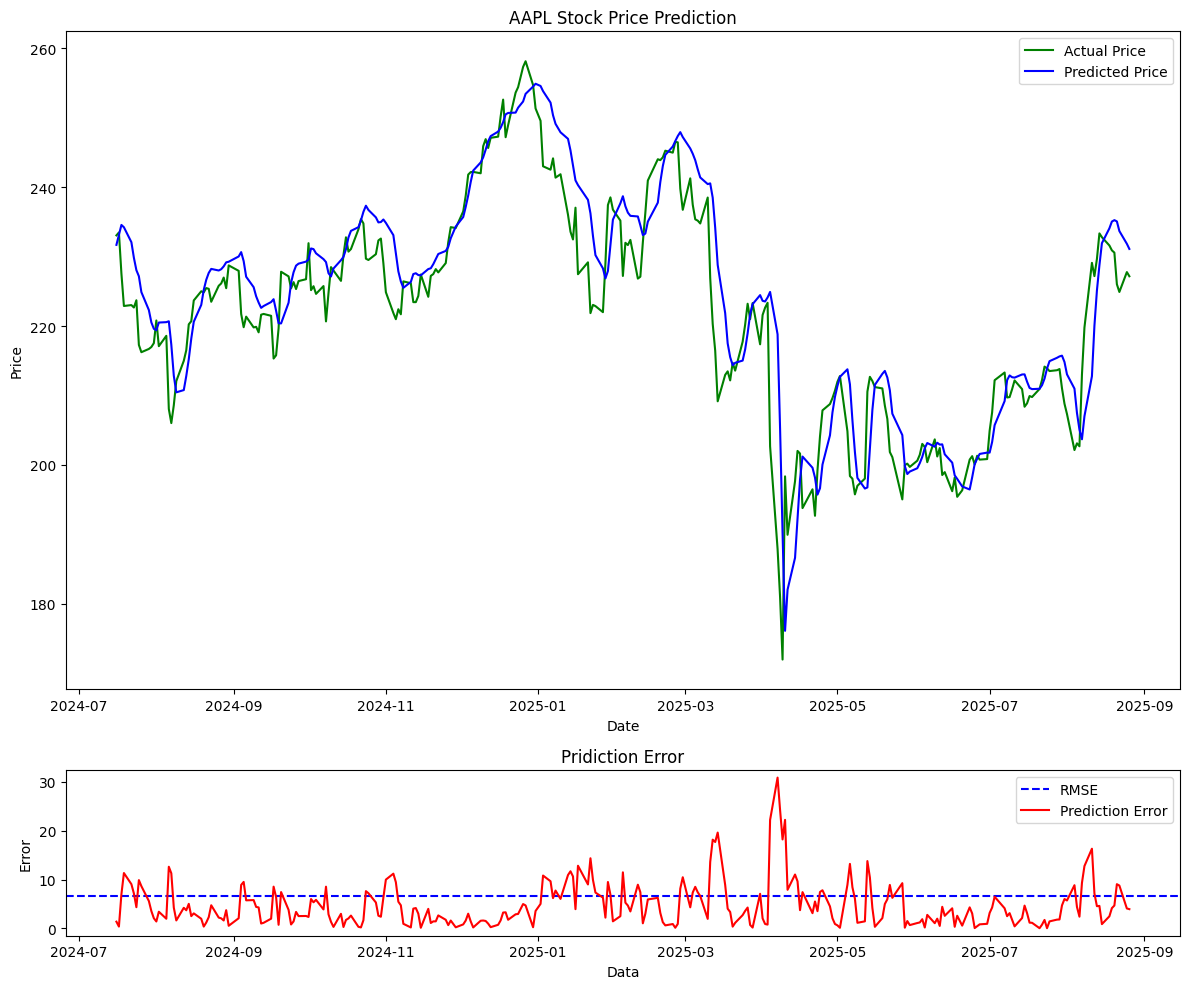

In [229]:
fig = plt.figure(figsize=(12, 10))

grid_spec = fig.add_gridspec(4, 1)

axis_1 = fig.add_subplot(grid_spec[:3, 0])
axis_1.plot(df.iloc[-len(y_test):].index, y_test, color='green', label = 'Actual Price')
axis_1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='blue', label = 'Predicted Price')
axis_1.legend()

plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")

axis_2 = fig.add_subplot(grid_spec[3, 0])
axis_2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
axis_2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), color='red', label = 'Prediction Error')
axis_2.legend()

plt.title('Pridiction Error')
plt.xlabel('Data')
plt.ylabel('Error')
plt.tight_layout()

plt.show()